In [3]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-11-2022)


In [4]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

In [5]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)

## Single Cases

In [6]:
true_energy = dataset_load.exposure.geom.axes[0].center.value

e_reco = 0.1
print(e_reco)

0.1


In [28]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0, 
                        tilt = 0,
                        rnd = False)
dataset_N = sys_d_cor.create_dataset_N()
dataset = sys_d_cor.create_dataset()
dataset_input = sys_d_cor.create_dataset()


with dataset_N.models.parameters.restore_status(): 
    dataset_N.models.parameters['e_reco'].value = e_reco
    dataset.counts = dataset_N.npred()
    dataset_N.counts = dataset_N.npred()


sigma_e = 0.1

penalising_covmatrix = [[1/sigma_e**2]]
penalising_invcovmatrix =  penalising_covmatrix
dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
#dataset_asimov.models.parameters['e_reco'].value = e_reco

datasets_N = Datasets(dataset_N)
datasets   = Datasets(dataset)

In [29]:
fit = Fit(store_trace=False)
result = fit.run(datasets)


In [30]:
fit_N = Fit(store_trace=False)
result_N = fit_N.run(datasets_N)


# Stat Profiles

## Stat Profiles for BKG Norm

In [32]:
computing_norm = 0
def make_writable(stat):
    write = dict()
    for k in stat.keys():
        if k != 'fit_results':
            write[k] = [float(i) for i in stat[k]]
            
                
    return write

In [33]:
%%time
if computing_norm :
    parameter = datasets[0].models.parameters['norm']
    sigma = 2
    parameter.scan_n_sigma  = sigma
    stat_profile = fit.stat_profile([datasets[0]], parameter, reoptimize= True)
    stat_profile['scale_scan'] = stat_profile.pop(next(iter(stat_profile)) )    
    with open('data/5_scan_norm.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile), file)
else:
    with open('data/5_scan_norm.yaml') as file:
        stat_profile = yaml.load( file, Loader=yaml.FullLoader)

    

CPU times: user 17.1 s, sys: 22.8 ms, total: 17.1 s
Wall time: 17.2 s


In [16]:
%%time
if computing_norm :
    parameter = datasets_N[0].models.parameters['norm']
    sigma = 2
    parameter.scan_n_sigma  = sigma
    stat_profile_N = fit.stat_profile([datasets_N[0]], parameter, reoptimize = True)
    stat_profile_N['scale_scan'] = stat_profile_N.pop(next(iter(stat_profile_N)) )    
    with open('data/5_scan_norm_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N), file)
    for k in stat_profile_N:
        if "spectral" in k:
            key_name = "scale_scan"
            stat_profile_N[key_name] = stat_profile_N[k]      
else:
    with open('data/5_scan_norm_N.yaml') as file:
        stat_profile_N = yaml.load( file, Loader=yaml.FullLoader)

    

CPU times: user 26.5 s, sys: 33 ms, total: 26.5 s
Wall time: 26.6 s


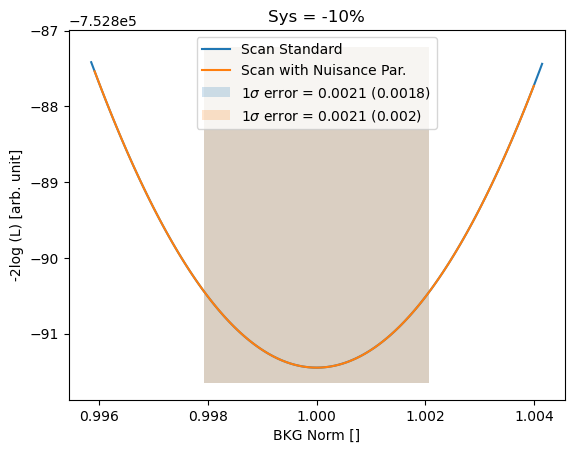

In [34]:
sys.path.append('/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Eff_area')
import upper_limit_18_02

fig = plt.figure()
ll_N = stat_profile_N.copy()
ul_N = upper_limit_18_02.upper_limit(ll_N,0,0)
L_N, x_N = ul_N.interpolate()
plt.plot(x_N, L_N(x_N),label ="Scan Standard")

ll = stat_profile.copy()
ul = upper_limit_18_02.upper_limit(ll,0,0)
L, x = ul.interpolate()
plt.plot(x, L(x),label ="Scan with Nuisance Par.")

norm_err_N = datasets_N[0].models.parameters['norm'].error
norm_err = datasets[0].models.parameters['norm'].error


min_, er, upp = ul_N.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err_N:.2})')
min_, er, upp = ul.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err:.2})')

plt.xlabel("BKG Norm []")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-4)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_norm.png")

## Stat Profiles for Source Signal

In [31]:
%%time
computing_amplitude = 0

if computing_amplitude:
    sigma = 2
    parameter_a = datasets[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_a = fit.stat_profile([datasets[0]], parameter_a, reoptimize= True)
    stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
    with open('data/5_scan_amplitude.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_a), file)
    
else:
    with open('data/5_scan_amplitude.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 25.4 s, sys: 24.7 ms, total: 25.4 s
Wall time: 25.5 s


In [20]:
%%time
if computing_amplitude:
    sigma = 2
    parameter_a = datasets_N[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_N_a = fit.stat_profile([datasets_N[0]], parameter_a, reoptimize = True)
    stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    
    
    with open('data/5_scan_amplitude_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_a), file)
    
else:
    with open('data/5_scan_amplitude_N.yaml') as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 23.3 s, sys: 23.8 ms, total: 23.3 s
Wall time: 23.4 s


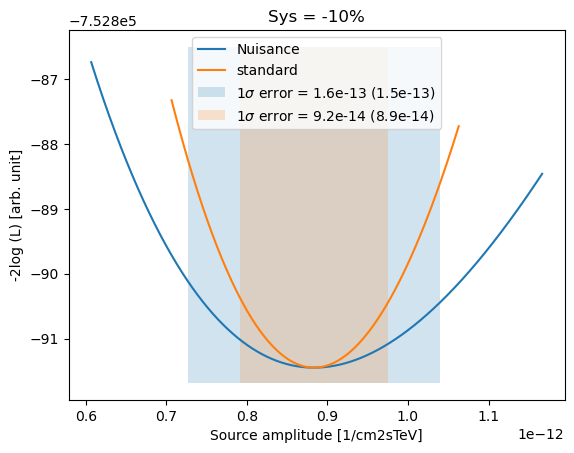

In [35]:
fig = plt.figure()
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard")

amplitude_err = datasets[0].models[0].parameters['amplitude'].error
amplitude_err_N = datasets_N[0].models[0].parameters['amplitude'].error



min_, er, upp = ul_N_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({amplitude_err_N:.2})')
min_, er, upp = ul_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({amplitude_err:.2})')

plt.xlabel("Source amplitude [1/cm2sTeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_amplitude.png")

## Stat Profiles for Source Index

In [36]:
%%time
computing_index = 1

if computing_index:
    sigma = 2
    parameter_i = datasets[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_i = fit.stat_profile([datasets[0]], parameter_i, reoptimize= True)
    stat_profile_i['scale_scan'] = stat_profile_i.pop(next(iter(stat_profile_i)) )    
    with open('data/5_scan_index.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_i), file)
    
else:
    with open('data/5_scan_index.yaml') as file:
        stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 23.1 s, sys: 26.8 ms, total: 23.1 s
Wall time: 23.2 s


In [37]:
%%time
if computing_index:
    sigma = 2
    parameter_i = datasets_N[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_N_i = fit.stat_profile([datasets_N[0]], parameter_i, reoptimize = True)
    stat_profile_N_i['scale_scan'] = stat_profile_N_i.pop(next(iter(stat_profile_N_i)) )    
    
    with open('data/5_scan_index_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_i), file)
    
else:
    with open('data/5_scan_index_N.yaml') as file:
        stat_profile_N_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 32.6 s, sys: 42.7 ms, total: 32.7 s
Wall time: 32.8 s


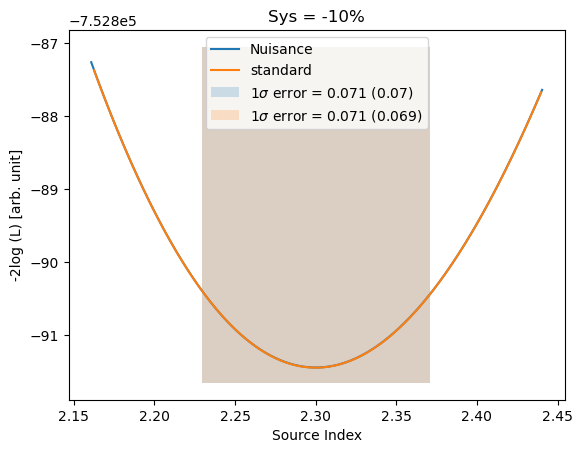

In [38]:
fig = plt.figure()
ll_N_a = stat_profile_N_i.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_i.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard")

index_err = datasets[0].models[0].parameters['index'].error
index_err_N = datasets_N[0].models[0].parameters['index'].error



min_, er, upp = ul_N_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({index_err_N:.2})')
min_, er, upp = ul_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({index_err:.2})')

plt.xlabel("Source Index")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_index.png")

## Penalty Examples

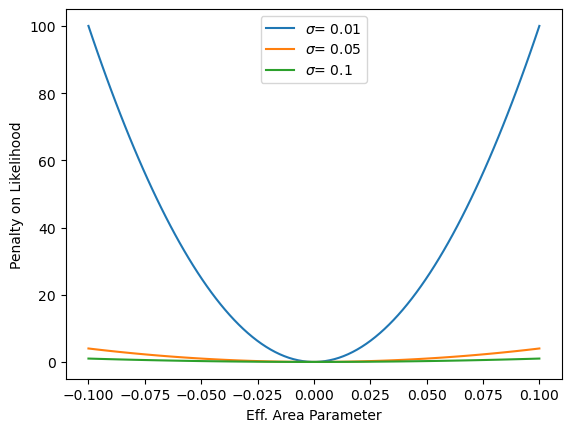

In [39]:
ps = [1e-2, 0.05, 0.1]
plot_values = np.linspace(-0.1, 0.1, 100)
for p in ps:
    plt.plot(plot_values, plot_values ** 2 / p ** 2, label = "$\sigma$= "+ str(p)) 
plt.legend()

plt.ylabel('Penalty on Likelihood')    
plt.xlabel('Eff. Area Parameter')
fig  = plt.gcf()
fig.savefig('plots/5_gaussian_penalty_example.pdf')